![alt text](http://pandas.pydata.org/_static/pandas_logo.png)

<center><h1> PANDAS TABLE OF CONTENTS </h1></center>

## [Group By: split-apply-combine](http://pandas.pydata.org/pandas-docs/stable/groupby.html) 

- [Splitting an object into groups](#Splitting-an-object-into-groups)
    - [GroupBy sorting](#GroupBy-sorting)
    - [GroupBy object attributes](#GroupBy-object-attributes)
    - [GroupBy with MultiIndex](#GroupBy-with-MultiIndex)
    - [DataFrame column selection in GroupBy](#DataFrame-column-selection-in-GroupBy)    
- [Iterating through groups](#Iterating-through-groups)     
- [Selecting a group](#Selecting-a-group)         
- [Aggregation](#Aggregation)        
    - [Applying multiple functions at once](#Applying-multiple-functions-at-once)    
    - [Applying different functions to DataFrame columns](#Applying-different-functions-to-DataFrame-columns) 
    - [Cython-optimized aggregation functions](#Cython-optimized-aggregation-functions) 
- [Transformation](#Transformation)     
- [Filtration](#Filtration)  
- [Dispatching to instance methods](#Dispatching-to-instance-methods) 
- [Flexible apply](#Flexible-apply)  
- [Other useful features](#Other-useful-features) 
    - [Automatic exclusion of “nuisance” columns](#Automatic-exclusion-of-“nuisance”-columns)  
    - [NA and NaT group handling](#NA-and-NaT-group-handling)
    - [Grouping with ordered factors](#Grouping-with-ordered-factors)
    - [Grouping with a Grouper specification](#Grouping-with-a-Grouper-specification)
    - [Taking the first rows of each group](#Taking-the-first-rows-of-each-group)
    - [Taking the nth row of each group](#Taking-the-nth-row-of-each-group)
    - [Enumerate group items](#Enumerate-group-items)
- [Examples](#Examples)    
    - [Regrouping by factor](#Regrouping-by-factor)  
    - [Returning a Series to propagate names](#Returning-a-Series-to-propagate-names) 



In [1]:
import pandas as pd
import numpy as np

By “group by” we are referring to a process involving one or more of the following steps

* **Splitting** the data into groups based on some criteria
* **Applying** a function to each group independently
* **Combining** the results into a data structure

Of these, the split step is the most straightforward. In fact, in many situations you may wish to split the data set into groups and do something with those groups yourself. In the apply step, we might wish to one of the following:

* **Aggregation:** computing a summary statistic (or statistics) about each group. Some examples:

  * Compute group sums or means
  * Compute group sizes / counts

* **Transformation:** perform some group-specific computations and return a like-indexed. Some examples:

  * Standardizing data (zscore) within group
  * Filling NAs within groups with a value derived from each group

* **Filtration:** discard some groups, according to a group-wise computation that evaluates True or False. Some examples:

  * Discarding data that belongs to groups with only a few members
  * Filtering out data based on the group sum or mean

* Some combination of the above: GroupBy will examine the results of the apply step and try to return a sensibly combined result if it doesn’t fit into either of the above two categories

Since the set of object instance method on pandas data structures are generally rich and expressive, we often simply want to invoke, say, a DataFrame function on each group. The name GroupBy should be quite familiar to those who have used a SQL-based tool (or itertools), in which you can write code like:

    SELECT Column1, Column2, mean(Column3), sum(Column4)
    FROM SomeTable
    GROUP BY Column1, Column2

We aim to make operations like this natural and easy to express using pandas. We’ll address each area of GroupBy functionality then provide some non-trivial examples / use cases.

See the [cookbook](http://pandas.pydata.org/pandas-docs/stable/cookbook.html#cookbook-grouping) for some advanced strategies

## Splitting an object into groups

pandas objects can be split on any of their axes. The abstract definition of grouping is to provide a mapping of labels to group names. To create a GroupBy object (more on what the GroupBy object is later), you do the following:

    >>> grouped = obj.groupby(key)
    >>> grouped = obj.groupby(key, axis=1)
    >>> grouped = obj.groupby([key1, key2])

The mapping can be specified many different ways:

* A Python function, to be called on each of the axis labels
* A list or NumPy array of the same length as the selected axis
* A dict or Series, providing a label -> group name mapping
* For DataFrame objects, a string indicating a column to be used to group. Of course df.groupby('A') is just syntactic sugar for df.groupby(df['A']), but it makes life simpler
* A list of any of the above things

Collectively we refer to the grouping objects as the **keys**. For example, consider the following DataFrame:

In [2]:
df = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                           'foo', 'bar', 'foo', 'foo'],
                   'B' : ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                   'C' : np.random.randn(8),
                   'D' : np.random.randn(8)})

In [3]:
df

,A,B,C,D
0,foo,one,0.597594,-0.858463
1,bar,one,0.036369,0.635320
2,foo,two,0.206096,1.029853
3,bar,three,-1.196350,0.456640
4,foo,two,-0.066740,1.188718
5,bar,two,0.826056,-1.140183
6,foo,one,-0.403127,-0.142852
7,foo,three,-1.055144,-1.413163


We could naturally group by either the A or B columns or both:

In [4]:
grouped = df.groupby('A')

In [5]:
grouped.count()

,B,C,D
A,,,
bar,3,3,3
foo,5,5,5


In [6]:
grouped = df.groupby(['A', 'B'])

In [7]:
grouped.count()

C  D
A   B          
bar one    1  1
    three  1  1
    two    1  1
foo one    2  2
    three  1  1
    two    2  2

In [8]:
def get_letter_type(letter):
    if letter.lower() in 'aeiou':
        return 'vowel'
    else:
        return 'consonant'

In [9]:
grouped = df.groupby(get_letter_type, axis=1)

In [10]:
grouped.count().iloc[0]

consonant    3
vowel        1
Name: 0, dtype: int64

Starting with 0.8, pandas Index objects now supports duplicate values. If a non-unique index is used as the group key in a groupby operation, all values for the same index value will be considered to be in one group and thus the output of aggregation functions will only contain unique index values:

In [11]:
lst = [1, 2, 3, 1, 2, 3]

In [12]:
s = pd.Series([1, 2, 3, 10, 20, 30], lst)

In [13]:
s

1     1
2     2
3     3
1    10
2    20
3    30
dtype: int64

In [14]:
grouped = s.groupby(level=0)

In [15]:
grouped.first()

1    1
2    2
3    3
dtype: int64

In [16]:
grouped.last()

1    10
2    20
3    30
dtype: int64

In [17]:
grouped.sum()

1    11
2    22
3    33
dtype: int64

Note that **no splitting occurs** until it’s needed. Creating the GroupBy object only verifies that you’ve passed a valid mapping.

**Note:** Many kinds of complicated data manipulations can be expressed in terms of GroupBy operations (though can’t be guaranteed to be the most efficient). You can get quite creative with the label mapping functions.

### GroupBy sorting

By default the group keys are sorted during the groupby operation. You may however pass sort=False for potential speedups:

In [18]:
df2 = pd.DataFrame({'X' : ['B', 'B', 'A', 'A'], 'Y' : [1, 2, 3, 4]})

In [19]:
df2

,X,Y
0,B,1
1,B,2
2,A,3
3,A,4


In [20]:
%%time
df2.groupby(['X']).sum()

Wall time: 2 ms


,Y
X,
A,7
B,3


In [21]:
%%time
df2.groupby(['X'], sort=False).sum()

Wall time: 2 ms


,Y
X,
B,3
A,7


Note that groupby will preserve the order in which observations are sorted within each group. For example, the groups created by groupby() below are in the order the appeared in the original DataFrame:

In [22]:
df3 = pd.DataFrame({'X' : ['A', 'B', 'A', 'B'], 'Y' : [1, 4, 3, 2]})

In [23]:
df3

,X,Y
0,A,1
1,B,4
2,A,3
3,B,2


In [24]:
df3.groupby(['X']).get_group('A')

,X,Y
0,A,1
2,A,3


In [25]:
df3.groupby(['X']).get_group('B')

,X,Y
1,B,4
3,B,2


### GroupBy object attributes

The groups attribute is a dict whose keys are the computed unique groups and corresponding values being the axis labels belonging to each group. In the above example we have:

In [26]:
df

,A,B,C,D
0,foo,one,0.597594,-0.858463
1,bar,one,0.036369,0.635320
2,foo,two,0.206096,1.029853
3,bar,three,-1.196350,0.456640
4,foo,two,-0.066740,1.188718
5,bar,two,0.826056,-1.140183
6,foo,one,-0.403127,-0.142852
7,foo,three,-1.055144,-1.413163


In [27]:
df.groupby('A').groups

{'bar': [1L, 3L, 5L], 'foo': [0L, 2L, 4L, 6L, 7L]}

In [28]:
 df.groupby(get_letter_type, axis=1).groups

{'consonant': ['B', 'C', 'D'], 'vowel': ['A']}

Calling the standard Python len function on the GroupBy object just returns the length of the groups dict, so it is largely just a convenience:

In [29]:
grouped = df.groupby(['A', 'B'])

In [30]:
grouped.groups

{('bar', 'one'): [1L],
 ('bar', 'three'): [3L],
 ('bar', 'two'): [5L],
 ('foo', 'one'): [0L, 6L],
 ('foo', 'three'): [7L],
 ('foo', 'two'): [2L, 4L]}

In [31]:
len(grouped)

6

GroupBy will tab complete column names (and other attributes)

### GroupBy with MultiIndex

With [hierarchically-indexed](http://pandas.pydata.org/pandas-docs/stable/advanced.html#advanced-hierarchical) data, it’s quite natural to group by one of the levels of the hierarchy.

Let’s create a series with a two-level MultiIndex.

In [32]:
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
          ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]

In [33]:
index = pd.MultiIndex.from_arrays(arrays, names=['first', 'second'])

In [34]:
s = pd.Series(np.random.randn(8), index=index)

In [35]:
s

first  second
bar    one       0.344146
       two      -0.170619
baz    one      -0.657360
       two       0.867299
foo    one       0.315489
       two       0.115062
qux    one       0.241589
       two      -1.430578
dtype: float64

We can then group by one of the levels in s.

In [36]:
grouped = s.groupby(level=0)

In [37]:
grouped.sum()

first
bar    0.173527
baz    0.209940
foo    0.430551
qux   -1.188989
dtype: float64

If the MultiIndex has names specified, these can be passed instead of the level number:

In [38]:
s.groupby(level='second').sum()

second
one    0.243864
two   -0.618836
dtype: float64

The aggregation functions such as sum will take the level parameter directly. Additionally, the resulting index will be named according to the chosen level:

In [39]:
s.sum(level='second')

second
one    0.243864
two   -0.618836
dtype: float64

In [40]:
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
          ['doo', 'doo', 'bee', 'bee', 'bop', 'bop', 'bop', 'bop'],
          ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]

In [41]:
index = pd.MultiIndex.from_arrays(arrays, names=['first', 'second','third'])

In [42]:
s = pd.Series(np.random.randn(8), index=index)

In [43]:
s

first  second  third
bar    doo     one     -1.102247
               two     -1.308720
baz    bee     one      0.238256
               two      1.003341
foo    bop     one     -1.006860
               two      0.021037
qux    bop     one     -0.019913
               two     -1.231651
dtype: float64

In [44]:
s.groupby(level=['first', 'second']).sum()

first  second
bar    doo      -2.410968
baz    bee       1.241597
foo    bop      -0.985822
qux    bop      -1.251564
dtype: float64

More on the sum function and aggregation later.

### DataFrame column selection in GroupBy

Once you have created the GroupBy object from a DataFrame, for example, you might want to do something different for each of the columns. Thus, using [] similar to getting a column from a DataFrame, you can do:

In [45]:
df

,A,B,C,D
0,foo,one,0.597594,-0.858463
1,bar,one,0.036369,0.635320
2,foo,two,0.206096,1.029853
3,bar,three,-1.196350,0.456640
4,foo,two,-0.066740,1.188718
5,bar,two,0.826056,-1.140183
6,foo,one,-0.403127,-0.142852
7,foo,three,-1.055144,-1.413163


In [46]:
grouped = df.groupby(['A'])

In [47]:
grouped_C = grouped['C']

In [48]:
grouped_D = grouped['D']

This is mainly syntactic sugar for the alternative and much more verbose:

In [49]:
df['C'].groupby(df['A'])

Additionally this method avoids recomputing the internal grouping information derived from the passed key.

## Iterating through groups

With the GroupBy object in hand, iterating through the grouped data is very natural and functions similarly to itertools.groupby:

In [50]:
grouped = df.groupby('A')

In [51]:
for name, group in grouped:
       print name 
       print '-' * len(name)
       print group
       print '\n'

bar
---
     A      B         C         D
1  bar    one  0.036369  0.635320
3  bar  three -1.196350  0.456640
5  bar    two  0.826056 -1.140183


foo
---
     A      B         C         D
0  foo    one  0.597594 -0.858463
2  foo    two  0.206096  1.029853
4  foo    two -0.066740  1.188718
6  foo    one -0.403127 -0.142852
7  foo  three -1.055144 -1.413163




In the case of grouping by multiple keys, the group name will be a tuple:

In [52]:
for name, group in df.groupby(['A', 'B']):
       print name 
       print '-' * 15
       print group
       print '\n'

('bar', 'one')
---------------
     A    B         C        D
1  bar  one  0.036369  0.63532


('bar', 'three')
---------------
     A      B        C        D
3  bar  three -1.19635  0.45664


('bar', 'two')
---------------
     A    B         C         D
5  bar  two  0.826056 -1.140183


('foo', 'one')
---------------
     A    B         C         D
0  foo  one  0.597594 -0.858463
6  foo  one -0.403127 -0.142852


('foo', 'three')
---------------
     A      B         C         D
7  foo  three -1.055144 -1.413163


('foo', 'two')
---------------
     A    B         C         D
2  foo  two  0.206096  1.029853
4  foo  two -0.066740  1.188718




It’s standard Python-fu but remember you can unpack the tuple in the for loop statement if you wish: for (k1, k2), group in grouped:.

## Selecting a group

A single group can be selected using GroupBy.get_group():

In [53]:
grouped.get_group('bar')

,A,B,C,D
1,bar,one,0.036369,0.635320
3,bar,three,-1.196350,0.456640
5,bar,two,0.826056,-1.140183


Or for an object grouped on multiple columns:

In [54]:
df.groupby(['A', 'B']).get_group(('bar', 'one'))

,A,B,C,D
1,bar,one,0.036369,0.63532


## Aggregation

Once the GroupBy object has been created, several methods are available to perform a computation on the grouped data.

An obvious one is aggregation via the aggregate or equivalently agg method:

In [55]:
grouped = df.groupby('A')

In [56]:
grouped.aggregate(np.sum)

,C,D
A,,
bar,-0.333926,-0.048223
foo,-0.721321,-0.195907


In [57]:
grouped = df.groupby(['A', 'B'])

In [58]:
grouped.aggregate(np.sum)

C         D
A   B                        
bar one    0.036369  0.635320
    three -1.196350  0.456640
    two    0.826056 -1.140183
foo one    0.194467 -1.001315
    three -1.055144 -1.413163
    two    0.139356  2.218571

As you can see, the result of the aggregation will have the group names as the new index along the grouped axis. In the case of multiple keys, the result is a [MultiIndex](http://pandas.pydata.org/pandas-docs/stable/advanced.html#advanced-hierarchical) by default, though this can be changed by using the as_index option:

In [59]:
grouped = df.groupby(['A', 'B'], as_index=False)

In [60]:
grouped.aggregate(np.sum)

,A,B,C,D
0,bar,one,0.036369,0.635320
1,bar,three,-1.196350,0.456640
2,bar,two,0.826056,-1.140183
3,foo,one,0.194467,-1.001315
4,foo,three,-1.055144,-1.413163
5,foo,two,0.139356,2.218571


In [61]:
df.groupby('A', as_index=False).sum()

,A,C,D
0,bar,-0.333926,-0.048223
1,foo,-0.721321,-0.195907


Note that you could use the reset_index DataFrame function to achieve the same result as the column names are stored in the resulting MultiIndex:

In [62]:
df.groupby(['A', 'B']).sum()

C         D
A   B                        
bar one    0.036369  0.635320
    three -1.196350  0.456640
    two    0.826056 -1.140183
foo one    0.194467 -1.001315
    three -1.055144 -1.413163
    two    0.139356  2.218571

In [63]:
df.groupby(['A', 'B']).sum().reset_index()

,A,B,C,D
0,bar,one,0.036369,0.635320
1,bar,three,-1.196350,0.456640
2,bar,two,0.826056,-1.140183
3,foo,one,0.194467,-1.001315
4,foo,three,-1.055144,-1.413163
5,foo,two,0.139356,2.218571


Another simple aggregation example is to compute the size of each group. This is included in GroupBy as the size method. It returns a Series whose index are the group names and whose values are the sizes of each group.

In [64]:
grouped = df.groupby(['A', 'B'])

In [65]:
grouped.size()

A    B    
bar  one      1
     three    1
     two      1
foo  one      2
     three    1
     two      2
dtype: int64

In [66]:

grouped['A'].count()

A    B    
bar  one      1
     three    1
     two      1
foo  one      2
     three    1
     two      2
Name: A, dtype: int64

In [67]:
grouped.describe().head(8)

C        D
A   B                           
bar one count  1.000000  1.00000
        mean   0.036369  0.63532
        std         NaN      NaN
        min    0.036369  0.63532
        25%    0.036369  0.63532
        50%    0.036369  0.63532
        75%    0.036369  0.63532
        max    0.036369  0.63532

**Note:** Aggregation functions **will not** return the groups that you are aggregating over if they are named columns, when as_index=True, the default. The grouped columns will be the **indices** of the returned object.

Passing as_index=False **will** return the groups that you are aggregating over, if they are named columns.

Aggregating functions are ones that reduce the dimension of the returned objects, for example: mean, sum, size, count, std, var, sem, describe, first, last, nth, min, max. This is what happens when you do for example DataFrame.sum() and get back a Series.

nth can act as a reducer or a filter, see [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html#groupby-nth)

### Applying multiple functions at once

With grouped Series you can also pass a list or dict of functions to do aggregation with, outputting a DataFrame:

In [68]:
grouped = df.groupby('A')

In [69]:
grouped['C'].agg([np.sum, np.mean, np.std])

,sum,mean,std
A,,,
bar,-0.333926,-0.111309,1.019259
foo,-0.721321,-0.144264,0.627660


If a dict is passed, the keys will be used to name the columns. Otherwise the function’s name (stored in the function object) will be used.

In [70]:
grouped['D'].agg({'result1' : np.sum,
                  'result2' : np.mean})

,result2,result1
A,,
bar,-0.016074,-0.048223
foo,-0.039181,-0.195907


On a grouped DataFrame, you can pass a list of functions to apply to each column, which produces an aggregated result with a hierarchical index:

In [71]:
grouped.agg([np.sum, np.mean, np.std])

C                             D                    
          sum      mean       std       sum      mean       std
A                                                              
bar -0.333926 -0.111309  1.019259 -0.048223 -0.016074  0.977598
foo -0.721321 -0.144264  0.627660 -0.195907 -0.039181  1.142406

Passing a dict of functions has different behavior by default, see the next section.

### Applying different functions to DataFrame columns

By passing a dict to aggregate you can apply a different aggregation to the columns of a DataFrame:

In [72]:
grouped.agg({'C' : np.sum,
             'D' : lambda x: np.std(x, ddof=1)})

,C,D
A,,
bar,-0.333926,0.977598
foo,-0.721321,1.142406


The function names can also be strings. In order for a string to be valid it must be either implemented on GroupBy or available via [dispatching](http://pandas.pydata.org/pandas-docs/stable/groupby.html#groupby-dispatch):

In [73]:
grouped.agg({'C' : 'sum', 'D' : 'std'})

,C,D
A,,
bar,-0.333926,0.977598
foo,-0.721321,1.142406


### Cython-optimized aggregation functions

Some common aggregations, currently only sum, mean, std, and sem, have optimized Cython implementations:

In [74]:
df.groupby('A').sum()

,C,D
A,,
bar,-0.333926,-0.048223
foo,-0.721321,-0.195907


In [75]:
df.groupby(['A', 'B']).mean()

C         D
A   B                        
bar one    0.036369  0.635320
    three -1.196350  0.456640
    two    0.826056 -1.140183
foo one    0.097234 -0.500657
    three -1.055144 -1.413163
    two    0.069678  1.109285

Of course sum and mean are implemented on pandas objects, so the above code would work even without the special versions via dispatching (see below).

## Transformation

The transform method returns an object that is indexed the same (same size) as the one being grouped. Thus, the passed transform function should return a result that is the same size as the group chunk. For example, suppose we wished to standardize the data within each group:

In [76]:
index = pd.date_range('10/1/1999', periods=1100)

In [77]:
ts = pd.Series(np.random.normal(0.5, 2, 1100), index)

In [78]:
ts = ts.rolling(window=100,min_periods=100).mean().dropna()

In [79]:
ts.head()

2000-01-08    0.454975
2000-01-09    0.435026
2000-01-10    0.450257
2000-01-11    0.475956
2000-01-12    0.487627
Freq: D, dtype: float64

In [80]:
ts.tail()

2002-09-30    0.261914
2002-10-01    0.217673
2002-10-02    0.200088
2002-10-03    0.243476
2002-10-04    0.252777
Freq: D, dtype: float64

In [81]:
key = lambda x: x.year

In [82]:
zscore = lambda x: (x - x.mean()) / x.std()

In [83]:
transformed = ts.groupby(key).transform(zscore)

In [84]:
# Original Data
grouped = ts.groupby(key)

In [85]:
grouped.mean()

2000    0.660557
2001    0.628612
2002    0.444309
dtype: float64

In [86]:
grouped.std()

2000    0.157209
2001    0.089818
2002    0.231149
dtype: float64

In [87]:
# Transformed Data
grouped_trans = transformed.groupby(key)

In [88]:
grouped_trans.mean()

2000    9.515756e-16
2001   -1.648605e-16
2002    2.237681e-15
dtype: float64

In [89]:
grouped_trans.std()

2000    1.0
2001    1.0
2002    1.0
dtype: float64

We can also visually compare the original and transformed data sets.

In [90]:
compare = pd.DataFrame({'Original': ts, 'Transformed': transformed})

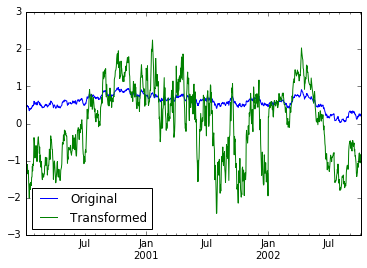

In [91]:
%matplotlib inline
compare.plot()

Another common data transform is to replace missing data with the group mean.

In [92]:
data_df = pd.DataFrame({'A' : np.random.randn(1000),
                        'B' : np.random.randn(1000),
                        'C' : np.random.randn(1000),
                        'D' : np.random.randn(1000)})

In [93]:
data_df.loc[100:200] = np.nan

In [94]:
countries = np.array(['US', 'UK', 'GR', 'JP'])

In [95]:
key = countries[np.random.randint(0, 4, 1000)]

In [96]:
grouped = data_df.groupby(key)

In [97]:
# Non-NA count in each group
grouped.count()

,A,B,C,D
GR,226,226,226,226
JP,221,221,221,221
UK,211,211,211,211
US,241,241,241,241


In [98]:
 f = lambda x: x.fillna(x.mean())

In [99]:
transformed = grouped.transform(f)

We can verify that the group means have not changed in the transformed data and that the transformed data contains no NAs.

In [100]:
grouped_trans = transformed.groupby(key)

In [101]:
 grouped.mean() # original group means

,A,B,C,D
GR,0.085082,0.101719,0.052297,-0.003176
JP,0.009631,-0.060430,-0.000929,-0.002654
UK,0.015781,0.065018,-0.061517,-0.172155
US,-0.144376,0.001215,-0.047906,-0.031643


In [102]:
grouped_trans.mean() # transformation did not change group means

,A,B,C,D
GR,0.085082,0.101719,0.052297,-0.003176
JP,0.009631,-0.060430,-0.000929,-0.002654
UK,0.015781,0.065018,-0.061517,-0.172155
US,-0.144376,0.001215,-0.047906,-0.031643


In [103]:
grouped.count() # original has some missing data points

,A,B,C,D
GR,226,226,226,226
JP,221,221,221,221
UK,211,211,211,211
US,241,241,241,241


In [104]:
grouped_trans.count() # counts after transformation

,A,B,C,D
GR,251,251,251,251
JP,241,241,241,241
UK,239,239,239,239
US,269,269,269,269


In [105]:
grouped_trans.size() # Verify non-NA count equals group size

GR    251
JP    241
UK    239
US    269
dtype: int64

**Note:** Some functions when applied to a groupby object will automatically transform the input, returning an object of the same shape as the original. Passing as_index=False will not affect these transformation methods.

For example: fillna, ffill, bfill, shift.

In [106]:
grouped

In [107]:
for name, group in grouped:
    print name +'\n', group

GR
            A         B         C         D
5   -0.381830 -2.164179  0.729214 -1.088658
10   2.408652  0.052215  1.004939  0.305062
11   1.008219  1.702496  1.233449 -0.450116
12  -0.762529 -0.425594 -0.763326 -0.046348
16  -0.187668  0.686710  2.120889  0.875121
17   0.090739  0.703273  0.732102  0.957090
30   0.260451  1.383924  0.650669  1.842083
31   0.732544  2.081639  0.408810  0.976137
32   1.872657  1.660527 -0.219898  0.054570
37  -1.920013 -0.547897  2.083330  0.048490
42   0.255447  1.232493  0.467271 -1.189463
43   1.086988 -0.702806  0.176497  1.182117
46  -1.121780  2.291669 -1.696670  0.195959
47   1.106992 -1.185687  0.500371  0.597125
48   0.423078 -1.646644  1.951364  0.049589
49   0.171014  0.017722  0.761820  2.244255
63  -1.611919 -0.241916  0.351977 -1.454643
66   0.995553 -0.235868  0.871885 -0.229757
67   0.120720  0.770140  0.261180 -0.443829
71   0.440406 -0.883043  2.490317 -0.642745
74   1.988647  0.054592  0.168370 -0.659132
80  -0.933408 -1.326843  1.20

In [108]:
grouped.ffill().loc[[80,100,111,112,114]]

,A,B,C,D
80,-0.933408,-1.326843,1.202039,0.399798
100,-0.381254,-0.161185,-0.365870,-0.321899
111,-0.381254,-0.161185,-0.365870,-0.321899
112,-1.523816,0.286659,0.983994,1.465718
114,-1.523816,0.286659,0.983994,1.465718


## Filtration

New in version 0.12.

The filter method returns a subset of the original object. Suppose we want to take only elements that belong to groups with a group sum greater than 2.

In [109]:
sf = pd.Series([1, 1, 2, 3, 3, 3])

In [110]:
sf

0    1
1    1
2    2
3    3
4    3
5    3
dtype: int64

In [111]:
sf.groupby(sf).filter(lambda x: x.sum() > 2)

3    3
4    3
5    3
dtype: int64

The argument of filter must be a function that, applied to the group as a whole, returns True or False.

Another useful operation is filtering out elements that belong to groups with only a couple members.

In [112]:
dff = pd.DataFrame({'A': np.arange(8), 'B': list('aabbbbcc')})

In [113]:
dff

,A,B
0,0,a
1,1,a
2,2,b
3,3,b
4,4,b
5,5,b
6,6,c
7,7,c


In [114]:
dff.groupby('B').size()

B
a    2
b    4
c    2
dtype: int64

In [115]:
dff.groupby('B').filter(lambda x: len(x) > 2)

,A,B
2,2,b
3,3,b
4,4,b
5,5,b


Alternatively, instead of dropping the offending groups, we can return a like-indexed objects where the groups that do not pass the filter are filled with NaNs.

In [116]:
dff.groupby('B').filter(lambda x: len(x) > 2, dropna=False)

,A,B
0,NaN,NaN
1,NaN,NaN
2,2.0,b
3,3.0,b
4,4.0,b
5,5.0,b
6,NaN,NaN
7,NaN,NaN


For dataframes with multiple columns, filters should explicitly specify a column as the filter criterion.

In [117]:
dff['C'] = np.arange(8)

In [118]:
dff

,A,B,C
0,0,a,0
1,1,a,1
2,2,b,2
3,3,b,3
4,4,b,4
5,5,b,5
6,6,c,6
7,7,c,7


In [119]:
dff.groupby('B').filter(lambda x: len(x['C']) > 2)

,A,B,C
2,2,b,2
3,3,b,3
4,4,b,4
5,5,b,5


In [120]:
dff.groupby('B').filter(lambda x: len(x['B']) > 2)

,A,B,C
2,2,b,2
3,3,b,3
4,4,b,4
5,5,b,5


In [121]:
dff.groupby('B').filter(lambda x: len(x['A']) > 2)

,A,B,C
2,2,b,2
3,3,b,3
4,4,b,4
5,5,b,5


**Note:** Some functions when applied to a groupby object will act as a filter on the input, returning a reduced shape of the original (and potentially eliminating groups), but with the index unchanged. Passing as_index=False will not affect these transformation methods.

For example: head, tail.

In [122]:
dff.groupby('B').head(1)

,A,B,C
0,0,a,0
2,2,b,2
6,6,c,6


## Dispatching to instance methods

When doing an aggregation or transformation, you might just want to call an instance method on each data group. This is pretty easy to do by passing lambda functions:

In [123]:
grouped = df.groupby('A')

In [124]:
grouped.agg(lambda x: x.std())

,C,D
A,,
bar,1.019259,0.977598
foo,0.627660,1.142406


But, it’s rather verbose and can be untidy if you need to pass additional arguments. Using a bit of metaprogramming cleverness, GroupBy now has the ability to “dispatch” method calls to the groups:

In [125]:
grouped.std()

,C,D
A,,
bar,1.019259,0.977598
foo,0.627660,1.142406


What is actually happening here is that a function wrapper is being generated. When invoked, it takes any passed arguments and invokes the function with any arguments on each group (in the above example, the std function). The results are then combined together much in the style of agg and transform (it actually uses apply to infer the gluing, documented next). This enables some operations to be carried out rather succinctly:

In [126]:
tsdf = pd.DataFrame(np.random.randn(1000, 3),
                    index=pd.date_range('1/1/2000', periods=1000),
                    columns=['A', 'B', 'C'])

In [127]:
tsdf.head()

,A,B,C
2000-01-01,-0.603341,0.892225,0.436753
2000-01-02,-1.092932,-0.885390,0.211917
2000-01-03,0.548788,-1.357746,-0.207447
2000-01-04,-2.252821,-0.296393,0.698778
2000-01-05,-1.120631,0.224246,1.160662


In [128]:
tsdf.ix[::2] = np.nan

In [129]:
grouped = tsdf.groupby(lambda x: x.year)

In [130]:
for name, group in grouped:
    print name, group

2000                    A         B         C
2000-01-01       NaN       NaN       NaN
2000-01-02 -1.092932 -0.885390  0.211917
2000-01-03       NaN       NaN       NaN
2000-01-04 -2.252821 -0.296393  0.698778
2000-01-05       NaN       NaN       NaN
2000-01-06  1.468915 -0.342376 -2.033195
2000-01-07       NaN       NaN       NaN
2000-01-08 -2.381300  0.158117 -0.754056
2000-01-09       NaN       NaN       NaN
2000-01-10 -0.183032  0.409059  1.750313
2000-01-11       NaN       NaN       NaN
2000-01-12 -1.391323 -1.490859  0.040686
2000-01-13       NaN       NaN       NaN
2000-01-14  0.997739  0.071105 -1.464020
2000-01-15       NaN       NaN       NaN
2000-01-16  0.581574 -1.186958 -1.866929
2000-01-17       NaN       NaN       NaN
2000-01-18  0.421496 -0.043556  0.250922
2000-01-19       NaN       NaN       NaN
2000-01-20  0.363401  2.395814  0.067110
2000-01-21       NaN       NaN       NaN
2000-01-22  0.782761  0.353848  0.052407
2000-01-23       NaN       NaN       NaN
2000-01-24 

In [131]:
grouped.fillna(method='pad').head()

,A,B,C
2000-01-01,NaN,NaN,NaN
2000-01-02,-1.092932,-0.885390,0.211917
2000-01-03,-1.092932,-0.885390,0.211917
2000-01-04,-2.252821,-0.296393,0.698778
2000-01-05,-2.252821,-0.296393,0.698778


In this example, we chopped the collection of time series into yearly chunks then independently called [fillna](http://pandas.pydata.org/pandas-docs/stable/missing_data.html#missing-data-fillna) on the groups.

New in version 0.14.1.

The nlargest and nsmallest methods work on Series style groupbys:

In [132]:
s = pd.Series([9, 8, 7, 5, 19, 1, 4.2, 3.3])

In [133]:
g = pd.Series(list('abababab'))

In [134]:
gb = s.groupby(g)

In [135]:
gb.groups

{'a': [0L, 2L, 4L, 6L], 'b': [1L, 3L, 5L, 7L]}

In [136]:
gb.nlargest(3)

a  4    19.0
   0     9.0
   2     7.0
b  1     8.0
   3     5.0
   7     3.3
dtype: float64

In [137]:
gb.nsmallest(3)

a  6    4.2
   2    7.0
   0    9.0
b  5    1.0
   7    3.3
   3    5.0
dtype: float64

## Flexible apply

Some operations on the grouped data might not fit into either the aggregate or transform categories. Or, you may simply want GroupBy to infer how to combine the results. For these, use the apply function, which can be substituted for both aggregate and transform in many standard use cases. However, apply can handle some exceptional use cases, for example:

In [138]:
df

,A,B,C,D
0,foo,one,0.597594,-0.858463
1,bar,one,0.036369,0.635320
2,foo,two,0.206096,1.029853
3,bar,three,-1.196350,0.456640
4,foo,two,-0.066740,1.188718
5,bar,two,0.826056,-1.140183
6,foo,one,-0.403127,-0.142852
7,foo,three,-1.055144,-1.413163


In [139]:
grouped = df.groupby('A')

In [140]:
# could also just call .describe()
grouped['C'].apply(lambda x: x.describe())

A         
bar  count    3.000000
     mean    -0.111309
     std      1.019259
     min     -1.196350
     25%     -0.579991
     50%      0.036369
     75%      0.431212
     max      0.826056
foo  count    5.000000
     mean    -0.144264
     std      0.627660
     min     -1.055144
     25%     -0.403127
     50%     -0.066740
     75%      0.206096
     max      0.597594
Name: C, dtype: float64

The dimension of the returned result can also change:

In [141]:
grouped = df.groupby('A')['C']

In [142]:
for name, group in grouped:
    print name
    print group

bar
1    0.036369
3   -1.196350
5    0.826056
Name: C, dtype: float64
foo
0    0.597594
2    0.206096
4   -0.066740
6   -0.403127
7   -1.055144
Name: C, dtype: float64


In [143]:
def f(group):
    return pd.DataFrame({'original' : group,
                         'demeaned' : group - group.mean()})

In [144]:
grouped.mean()

A
bar   -0.111309
foo   -0.144264
Name: C, dtype: float64

In [145]:
#Subtracting the mean of each group i.e.  index 0 below is -0.610667 - -0.970933 since it was grouped with foo
grouped.apply(f)

,demeaned,original
0,0.741859,0.597594
1,0.147677,0.036369
2,0.350360,0.206096
3,-1.085042,-1.196350
4,0.077524,-0.066740
5,0.937364,0.826056
6,-0.258863,-0.403127
7,-0.910880,-1.055144


apply on a Series can operate on a returned value from the applied function, that is itself a series, and possibly upcast the result to a DataFrame

In [146]:
def f(x):
    return pd.Series([ x, x**2 ], index = ['x', 'x^2'])

In [147]:
s

0     9.0
1     8.0
2     7.0
3     5.0
4    19.0
5     1.0
6     4.2
7     3.3
dtype: float64

In [148]:
 s.apply(f)

,x,x^2
0,9.0,81.00
1,8.0,64.00
2,7.0,49.00
3,5.0,25.00
4,19.0,361.00
5,1.0,1.00
6,4.2,17.64
7,3.3,10.89


**Note:** apply can act as a reducer, transformer, or filter function, depending on exactly what is passed to apply. So depending on the path taken, and exactly what you are grouping. Thus the grouped columns(s) may be included in the output as well as set the indices.

**Warning:** In the current implementation apply calls func twice on the first group to decide whether it can take a fast or slow code path. This can lead to unexpected behavior if func has side-effects, as they will take effect twice for the first group.

In [149]:
d = pd.DataFrame({"a":["x", "y"], "b":[1,2]})

In [150]:
def identity(df):
    print df
    return df

In [151]:
d

,a,b
0,x,1
1,y,2


In [152]:
d.groupby("a").apply(identity)

   a  b
0  x  1
   a  b
0  x  1
   a  b
1  y  2


,a,b
0,x,1
1,y,2


## Other useful features

### Automatic exclusion of “nuisance” columns

Again consider the example DataFrame we’ve been looking at:

In [153]:
df

,A,B,C,D
0,foo,one,0.597594,-0.858463
1,bar,one,0.036369,0.635320
2,foo,two,0.206096,1.029853
3,bar,three,-1.196350,0.456640
4,foo,two,-0.066740,1.188718
5,bar,two,0.826056,-1.140183
6,foo,one,-0.403127,-0.142852
7,foo,three,-1.055144,-1.413163


Supposed we wished to compute the standard deviation grouped by the A column. There is a slight problem, namely that we don’t care about the data in column B. We refer to this as a “nuisance” column. If the passed aggregation function can’t be applied to some columns, the troublesome columns will be (silently) dropped. Thus, this does not pose any problems:

In [154]:
df.groupby('A').std()

,C,D
A,,
bar,1.019259,0.977598
foo,0.627660,1.142406


### NA and NaT group handling

If there are any NaN or NaT values in the grouping key, these will be automatically excluded. So there will never be an “NA group” or “NaT group”. This was not the case in older versions of pandas, but users were generally discarding the NA group anyway (and supporting it was an implementation headache).

### Grouping with ordered factors

Categorical variables represented as instance of pandas’s Categorical class can be used as group keys. If so, the order of the levels will be preserved:

In [155]:
data = pd.Series(np.random.randn(100))

In [156]:
factor = pd.qcut(data, [0, .25, .5, .75, 1.])

In [157]:
data.head()

0    0.184291
1   -0.002742
2    2.486379
3    0.579813
4    0.722885
dtype: float64

In [158]:
data.groupby(factor).mean()

[-2.658, -0.532]   -1.214585
(-0.532, 0.0508]   -0.277075
(0.0508, 0.665]     0.315080
(0.665, 3.483]      1.361910
dtype: float64

### Grouping with a Grouper specification

You may need to specify a bit more data to properly group. You can use the pd.Grouper to provide this local control.

In [159]:
import datetime

In [160]:
df = pd.DataFrame({
         'Branch' : 'A A A A A A A B'.split(),
         'Buyer': 'Carl Mark Carl Carl Joe Joe Joe Carl'.split(),
         'Quantity': [1,3,5,1,8,1,9,3],
         'Date' : [
             datetime.datetime(2013,1,1,13,0),
             datetime.datetime(2013,1,1,13,5),
             datetime.datetime(2013,10,1,20,0),
             datetime.datetime(2013,10,2,10,0),
             datetime.datetime(2013,10,1,20,0),
             datetime.datetime(2013,10,2,10,0),
             datetime.datetime(2013,12,2,12,0),
             datetime.datetime(2013,12,2,14,0),
             ]
         })

In [161]:
df

,Branch,Buyer,Date,Quantity
0,A,Carl,2013-01-01 13:00:00,1
1,A,Mark,2013-01-01 13:05:00,3
2,A,Carl,2013-10-01 20:00:00,5
3,A,Carl,2013-10-02 10:00:00,1
4,A,Joe,2013-10-01 20:00:00,8
5,A,Joe,2013-10-02 10:00:00,1
6,A,Joe,2013-12-02 12:00:00,9
7,B,Carl,2013-12-02 14:00:00,3


Groupby a specific column with the desired frequency. This is like resampling.

In [162]:
 df.groupby([pd.Grouper(freq='1M',key='Date'),'Buyer']).sum()

Quantity
Date       Buyer          
2013-01-31 Carl          1
           Mark          3
2013-10-31 Carl          6
           Joe           9
2013-12-31 Carl          3
           Joe           9

You have an ambiguous specification in that you have a named index and a column that could be potential groupers.

In [163]:
df = df.set_index('Date')

In [164]:
df

,Branch,Buyer,Quantity
Date,,,
2013-01-01 13:00:00,A,Carl,1
2013-01-01 13:05:00,A,Mark,3
2013-10-01 20:00:00,A,Carl,5
2013-10-02 10:00:00,A,Carl,1
2013-10-01 20:00:00,A,Joe,8
2013-10-02 10:00:00,A,Joe,1
2013-12-02 12:00:00,A,Joe,9
2013-12-02 14:00:00,B,Carl,3


In [165]:
df['Date'] = df.index + pd.offsets.MonthEnd(2)

In [166]:
df

,Branch,Buyer,Quantity,Date
Date,,,,
2013-01-01 13:00:00,A,Carl,1,2013-02-28 13:00:00
2013-01-01 13:05:00,A,Mark,3,2013-02-28 13:05:00
2013-10-01 20:00:00,A,Carl,5,2013-11-30 20:00:00
2013-10-02 10:00:00,A,Carl,1,2013-11-30 10:00:00
2013-10-01 20:00:00,A,Joe,8,2013-11-30 20:00:00
2013-10-02 10:00:00,A,Joe,1,2013-11-30 10:00:00
2013-12-02 12:00:00,A,Joe,9,2014-01-31 12:00:00
2013-12-02 14:00:00,B,Carl,3,2014-01-31 14:00:00


In [167]:
df.groupby([pd.Grouper(freq='6M',key='Date'),'Buyer']).sum()

Quantity
Date       Buyer          
2013-02-28 Carl          1
           Mark          3
2014-02-28 Carl          9
           Joe          18

In [168]:
df.groupby([pd.Grouper(freq='6M',level='Date'),'Buyer']).sum()

Quantity
Date       Buyer          
2013-01-31 Carl          1
           Mark          3
2014-01-31 Carl          9
           Joe          18

### Taking the first rows of each group

Just like for a DataFrame or Series you can call head and tail on a groupby:

In [169]:
df = pd.DataFrame([[1, 2], [1, 4], [5, 6]], columns=['A', 'B'])

In [170]:
df

,A,B
0,1,2
1,1,4
2,5,6


In [171]:
g = df.groupby('A')

In [172]:
for name, group in g:
    print name
    print group

1
   A  B
0  1  2
1  1  4
5
   A  B
2  5  6


In [173]:
g.head(1)

,A,B
0,1,2
2,5,6


In [174]:
g.tail(1)

,A,B
1,1,4
2,5,6


This shows the first or last n rows from each group.

**Warning:** Before 0.14.0 this was implemented with a fall-through apply, so the result would incorrectly respect the as_index flag:

In [175]:
g.head(1)  # was equivalent to g.apply(lambda x: x.head(1))

,A,B
0,1,2
2,5,6


### Taking the nth row of each group

To select from a DataFrame or Series the nth item, use the nth method. This is a reduction method, and will return a single row (or no row) per group if you pass an int for n:

In [176]:
df = pd.DataFrame([[1, np.nan], [1, 4], [5, 6]], columns=['A', 'B'])

In [177]:
df

,A,B
0,1,NaN
1,1,4.0
2,5,6.0


In [178]:
g = df.groupby('A')

In [179]:
g.nth(0)

,B
A,
1,NaN
5,6.0


In [180]:
g.nth(-1)

,B
A,
1,4.0
5,6.0


In [181]:
g.nth(1)

,B
A,
1,4.0


If you want to select the nth not-null item, use the dropna kwarg. For a DataFrame this should be either 'any' or 'all' just like you would pass to dropna, for a Series this just needs to be truthy.

In [182]:
# nth(0) is the same as g.first()
g.nth(0, dropna='any')

,B
A,
1,4.0
5,6.0


In [183]:
g.first()

,B
A,
1,4.0
5,6.0


In [184]:
# nth(-1) is the same as g.last()
g.nth(-1, dropna='any')  # NaNs denote group exhausted when using dropna

,B
A,
1,4.0
5,6.0


In [185]:
g.last()

,B
A,
1,4.0
5,6.0


In [186]:
g.B.nth(0, dropna=True)

A
1    4.0
5    6.0
Name: B, dtype: float64

As with other methods, passing as_index=False, will achieve a filtration, which returns the grouped row.

In [187]:
df = pd.DataFrame([[1, np.nan], [1, 4], [5, 6]], columns=['A', 'B'])

In [188]:
df

,A,B
0,1,NaN
1,1,4.0
2,5,6.0


In [189]:
g = df.groupby('A',as_index=False)

In [190]:
g.nth(0)

,A,B
0,1,NaN
2,5,6.0


In [191]:
g.nth(-1)

,A,B
1,1,4.0
2,5,6.0


You can also select multiple rows from each group by specifying multiple nth values as a list of ints.

In [192]:
business_dates = pd.date_range(start='4/1/2014', end='6/30/2014', freq='B')

In [193]:
df = pd.DataFrame(1, index=business_dates, columns=['a', 'b'])

In [194]:
df.head(10)

,a,b
2014-04-01,1,1
2014-04-02,1,1
2014-04-03,1,1
2014-04-04,1,1
2014-04-07,1,1
2014-04-08,1,1
2014-04-09,1,1
2014-04-10,1,1
2014-04-11,1,1
2014-04-14,1,1


In [195]:
# get the first, 4th, and last date index for each month
df.groupby((df.index.year, df.index.month)).nth([0, 3, -1])

a  b
2014 4  1  1
     4  1  1
     4  1  1
     5  1  1
     5  1  1
     5  1  1
     6  1  1
     6  1  1
     6  1  1

### Enumerate group items

New in version 0.13.0.

To see the order in which each row appears within its group, use the cumcount method:

In [196]:
df = pd.DataFrame(list('aaabba'), columns=['A'])

In [197]:
df

,A
0,a
1,a
2,a
3,b
4,b
5,a


In [198]:
df.groupby('A').cumcount()

0    0
1    1
2    2
3    0
4    1
5    3
dtype: int64

In [199]:
df.groupby('A').cumcount(ascending=False)  # kwarg only

0    3
1    2
2    1
3    1
4    0
5    0
dtype: int64

## Examples

### Regrouping by factor

Regroup columns of a DataFrame according to their sum, and sum the aggregated ones.

In [200]:
df = pd.DataFrame({'a':[1,0,0], 'b':[0,1,0], 'c':[1,0,0], 'd':[2,3,4]})

In [201]:
df

,a,b,c,d
0,1,0,1,2
1,0,1,0,3
2,0,0,0,4


In [202]:
grouped = df.groupby(df.sum(), axis=1)

In [203]:
for name, group in grouped:
    print '\n'
    print name
    print group



1
   a  b  c
0  1  0  1
1  0  1  0
2  0  0  0


9
   d
0  2
1  3
2  4


In [204]:
grouped.sum()

,1,9
0,2,2
1,1,3
2,0,4


### Returning a Series to propagate names

Group DataFrame columns, compute a set of metrics and return a named Series. The Series name is used as the name for the column index. This is especially useful in conjunction with reshaping operations such as stacking in which the column index name will be used as the name of the inserted column:

In [205]:
df = pd.DataFrame({
         'a':  [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2],
         'b':  [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
         'c':  [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
         'd':  [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
         })

In [206]:
df

,a,b,c,d
0,0,0,1,0
1,0,0,0,0
2,0,1,1,0
3,0,1,0,1
4,1,0,1,0
5,1,0,0,0
6,1,1,1,0
7,1,1,0,1
8,2,0,1,0
9,2,0,0,0


In [207]:
def compute_metrics(x):
    result = {'b_sum': x['b'].sum(), 'c_mean': x['c'].mean()}
    return pd.Series(result, name='metrics')

In [208]:
result = df.groupby('a').apply(compute_metrics)

In [209]:
result

metrics,b_sum,c_mean
a,,
0,2.0,0.5
1,2.0,0.5
2,2.0,0.5


In [210]:
result.stack()

a  metrics
0  b_sum      2.0
   c_mean     0.5
1  b_sum      2.0
   c_mean     0.5
2  b_sum      2.0
   c_mean     0.5
dtype: float64